In [1]:
import os
import tensorflow as tf
import gym
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense 

import numpy as np
import matplotlib.pyplot as plt

2022-09-19 15:23:44.537723: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class ActorCriticNetwork(keras.Model):
    # number-of-actions, first layer,   
    def __init__(self, n_actions, fc1_dims=1024, fc2_dims=512,
            name='actor_critic', chkpt_dir='tmp/actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.v = Dense(1, activation=None) # Output: value function
        self.pi = Dense(n_actions, activation='softmax') # Output: Policy Pi

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi

In [3]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [4]:
class Agent:
    def __init__(self, alpha=0.0003, gamma=0.99, n_actions=2):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.action_space = [i for i in range(self.n_actions)]

        self.actor_critic = ActorCriticNetwork(n_actions=n_actions)

        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))


    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        _, probs = self.actor_critic(state)

        action_probabilities = tfp.distributions.Categorical(probs=probs)
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action

        return action.numpy()[0]

    def save_models(self):
        print('... saving models ...')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    def learn(self, state, reward, state_, done):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN
        with tf.GradientTape(persistent=True) as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)

            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            delta = reward + self.gamma*state_value_*(1-int(done)) - state_value
            actor_loss = -log_prob*delta
            critic_loss = delta**2
            total_loss = actor_loss + critic_loss

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        self.actor_critic.optimizer.apply_gradients(zip(
            gradient, self.actor_critic.trainable_variables))



... saving models ...
episode  0 score 16.0 avg_score 16.0
... saving models ...
episode  1 score 23.0 avg_score 19.5
... saving models ...
episode  2 score 24.0 avg_score 21.0
... saving models ...
episode  3 score 22.0 avg_score 21.2
episode  4 score 15.0 avg_score 20.0
episode  5 score 25.0 avg_score 20.8
episode  6 score 17.0 avg_score 20.3
... saving models ...
episode  7 score 44.0 avg_score 23.2
episode  8 score 12.0 avg_score 22.0
episode  9 score 33.0 avg_score 23.1
episode  10 score 14.0 avg_score 22.3
episode  11 score 21.0 avg_score 22.2
episode  12 score 27.0 avg_score 22.5
episode  13 score 17.0 avg_score 22.1
episode  14 score 15.0 avg_score 21.7
episode  15 score 16.0 avg_score 21.3
episode  16 score 16.0 avg_score 21.0
episode  17 score 50.0 avg_score 22.6
episode  18 score 11.0 avg_score 22.0
episode  19 score 19.0 avg_score 21.9
episode  20 score 22.0 avg_score 21.9
episode  21 score 19.0 avg_score 21.7
episode  22 score 39.0 avg_score 22.5
episode  23 score 22.0 avg

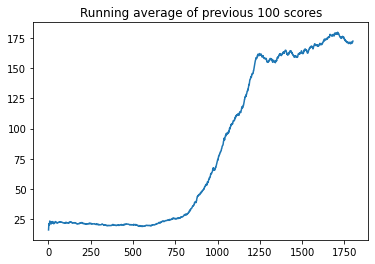

In [9]:
#env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v0')
agent = Agent(alpha=1e-5, n_actions=env.action_space.n)
n_games = 1800
# uncomment this line and do a mkdir tmp && mkdir video if you want to
# record video of the agent playing the game.
#env = wrappers.Monitor(env, 'tmp/video', video_callable=lambda episode_id: True, force=True)
filename = 'cartpole_1e-5_1024x512_1800games.png'

figure_file = 'img/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

if load_checkpoint:
    agent.load_models()

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.learn(observation, reward, observation_, done)
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

In [8]:
observation = env.reset()
print(observation[0])

-0.013050579
